,date,parspread,short,long,cds_gap
59,2001-06-19,0.010451,0.009450,0.012248,-0.002798
60,2001-06-20,0.010451,0.009700,0.012219,-0.002518
61,2001-06-21,0.010089,0.009878,0.012184,-0.002306
62,2001-06-22,0.010056,0.010049,0.012151,-0.002101
63,2001-06-25,0.010056,0.010220,0.012118,-0.001897
...,...,...,...,...,...
6470,2026-01-19,0.001944,0.001925,0.002489,-0.000565
6471,2026-01-20,0.001940,0.001929,0.002484,-0.000555
6472,2026-01-21,0.001940,0.001933,0.002478,-0.000545
6473,2026-01-22,0.001915,0.001929,0.002472,-0.000542


[*********************100%***********************]  1 of 1 completed


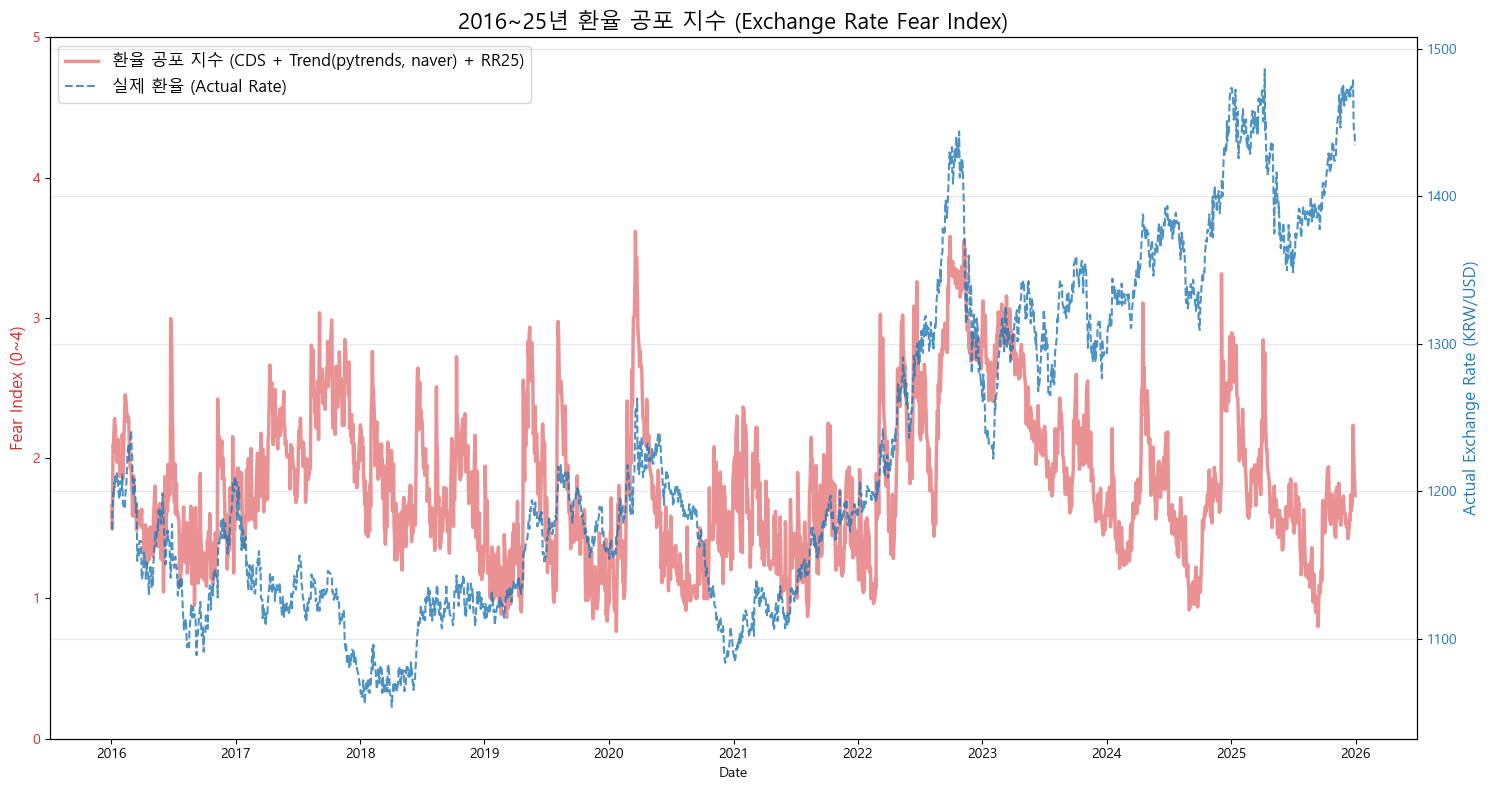

            parspread     short      long   cds_gap   변동성     Gap_60   합  \
date                                                                       
2016-01-04   0.005020  0.004886  0.005079 -0.000193   9.7  31.185000  41   
2016-01-05   0.004969  0.004904  0.005074 -0.000171   8.4  31.040000  40   
2016-01-06   0.005193  0.004976  0.005070 -0.000095  10.7  40.291667  43   
2016-01-07   0.005516  0.005109  0.005068  0.000042   7.4  42.040000  47   
2016-01-08   0.005424  0.005225  0.005065  0.000159  10.0  38.733333  41   

              네이버검색량     RR    real_rate  60_gap_norm  gap_norm  trend_norm  \
date                                                                          
2016-01-04  10.36926  0.363  1174.109985     0.642290  0.171134    0.272727   
2016-01-05  11.08535  0.038  1187.359985     0.641559  0.144330    0.263636   
2016-01-06  11.92462  0.338  1188.719971     0.688224  0.191753    0.290909   
2016-01-07  13.98070  0.375  1198.739990     0.697043  0.123711    0.327

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# 일별 환율 고가-저가 변동성 (2014~2025)
exchange_rate_df = pd.read_csv('../dataset/일별 고가-저가 14-25.csv')

# 환율 120일 장기 평균과의 차이 (2014~2025)
avg_gap = pd.read_csv("../dataset/60일 평균값 대비 환율 14-25.csv")

# 일별 국채 CDS 가격 (2001~2025)
cds_df = pd.read_csv('../dataset/KOREA CDS 2001-2025.csv')
cds_df['date'] = pd.to_datetime(cds_df['date'].astype(str).str.replace(' ', ''))
cds_df = cds_df.sort_values('date')

# 일별 환율 관련 pytrend 검색량 (환율 + 원달러. 2094~2025)
pytrends_df = pd.read_csv("../dataset/data/exchange_rate_2004_2025_merged.csv")

# 일별 환율 관련 네이버 검색량 (환율 + 원달러. 2016~2025)
navertrends_df = pd.read_csv("../dataset/네이버검색량.csv")

# Risk Reversal 25 (2014~2025)
df_rr = pd.read_excel('../dataset/data/1M.xlsx') 
df_rr = df_rr.iloc[:, :2]
df_rr.columns = ['date', 'RR']


import platform
if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 1. 데이터 전처리: 날짜 컬럼 통일 및 Datetime 변환
# CDS Data (날짜 -> date)
cds_prep = cds_df.copy()
cds_prep['date'] = pd.to_datetime(cds_prep['date'])
cds_prep = cds_prep[['date', 'parspread']] # 필요한 컬럼만 선택
cds_prep['short'] = cds_prep['parspread'].rolling(5, min_periods=1).mean() # 5일 CDS 평균치
cds_prep['long']  = cds_prep['parspread'].rolling(252, min_periods=60).mean() # 252일 CDS 평균치
cds_prep['cds_gap'] = cds_prep['short'] - cds_prep['long'] # 5일평균 - 252일평균 (최근 변화량)
cds_prep = cds_prep.dropna()
display(cds_prep)

# Exchange Rate Gap Data (Unnamed: 0 -> date)
gap_prep = exchange_rate_df.copy()
gap_prep['date'] = pd.to_datetime(gap_prep['date'])
gap_prep = gap_prep[['date', '변동성']]

# 60 Days Gap Data 
avg_gap_prep = avg_gap.copy()
avg_gap_prep['date'] = pd.to_datetime(avg_gap_prep['date'])
avg_gap_prep = avg_gap_prep[['date', 'Gap_60']]

# Pytrends Data (date 컬럼 그대로 사용)
trend_prep = pytrends_df.copy()
trend_prep['date'] = pd.to_datetime(trend_prep['date'])
trend_prep = trend_prep[['date', '합']]

# Naver Datalab Data (date 컬럼 그대로 사용)
naver_prep = navertrends_df.copy()
naver_prep['date'] = pd.to_datetime(naver_prep['date'])
naver_prep = naver_prep[['date', '네이버검색량']]

# RR25 데이터
rr25_prep = df_rr.copy()
rr25_prep['date'] = pd.to_datetime(rr25_prep['date'], dayfirst=True, errors='coerce')
rr25_prep['RR'] = pd.to_numeric(rr25_prep['RR'], errors='coerce')
rr25_prep = rr25_prep.dropna().sort_values('date')

real_er = yf.download('KRW=X', start='2014-01-01', end='2025-12-31')

# yfinance MultiIndex 컬럼 처리 (에러 방지)
if isinstance(real_er.columns, pd.MultiIndex):
    real_er.columns = real_er.columns.get_level_values(0)

real_er = real_er.reset_index()
if 'Date' in real_er.columns:
    real_er = real_er.rename(columns={'Date': 'date'})
real_er['date'] = pd.to_datetime(real_er['date']).dt.tz_localize(None)
real_er = real_er[['date', 'Close']].rename(columns={'Close': 'real_rate'})

# 2. 데이터 병합 (Inner Join으로 모든 데이터가 존재하는 날짜만 남김)
merged_df = pd.merge(cds_prep, gap_prep, on='date', how='inner')
merged_df = pd.merge(merged_df, avg_gap_prep, on='date', how='inner') 
merged_df = pd.merge(merged_df, trend_prep, on='date', how='inner')
merged_df = pd.merge(merged_df, naver_prep, on='date', how='inner')
merged_df = pd.merge(merged_df, rr25_prep, on='date', how='inner')
merged_df = pd.merge(merged_df, real_er, on='date', how='inner')

# 날짜순 정렬 및 인덱스 설정
merged_df = merged_df.sort_values('date').set_index('date')

# 3. 정규화 (0~1 Scaling) 함수 정의
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# 각 지표 정규화 적용
merged_df['60_gap_norm'] = min_max_normalize(merged_df['Gap_60']) 
merged_df['gap_norm'] = min_max_normalize(merged_df['변동성'])
merged_df['trend_norm'] = min_max_normalize(merged_df['합'])
#merged_df['navertrend_norm'] = min_max_normalize(merged_df['네이버검색량'])
merged_df['navertrend_norm'] = merged_df['네이버검색량'].rank(pct=True)
merged_df['cds_norm'] = min_max_normalize(merged_df['cds_gap'])
merged_df['RR_norm'] = merged_df['RR'].rank(pct=True)


# 4. 환율 공포 지수 생성 (정규화 값들의 합)
# merged_df['fear_index'] = merged_df['cds_norm'] + merged_df['trend_norm'] + merged_df['gap_norm'] + merged_df['60_gap_norm'] + merged_df['RR_Z']
# merged_df['fear_index'] = merged_df['cds_norm'] + merged_df['trend_norm'] + merged_df['60_gap_norm']
merged_df['fear_index'] = merged_df['cds_norm'] + merged_df['RR_norm'] + merged_df['trend_norm'] + merged_df['navertrend_norm']

# 시각화 (이중 축 그래프)
fig, ax1 = plt.subplots(figsize=(15, 8))

# [왼쪽 축] 환율 공포 지수 (빨강)
ax1.set_xlabel('Date')
ax1.set_ylabel('Fear Index (0~4)', color='tab:red', fontsize=12)
line1 = ax1.plot(merged_df.index, merged_df['fear_index'], color='tab:red', label='환율 공포 지수 (CDS + Trend(pytrends, naver) + RR25)', linewidth=2.5, alpha=0.5)
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0.0, 5.0) 

# [오른쪽 축] 실제 환율 (파랑)
ax2 = ax1.twinx()
ax2.set_ylabel('Actual Exchange Rate (KRW/USD)', color='tab:blue', fontsize=12)
line2 = ax2.plot(merged_df.index, merged_df['real_rate'], color='tab:blue', label='실제 환율 (Actual Rate)', linestyle='--', alpha=0.8)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# 범례 통합
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=12)

plt.title('2016~25년 환율 공포 지수 (Exchange Rate Fear Index)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

# 데이터 확인
print(merged_df.head())

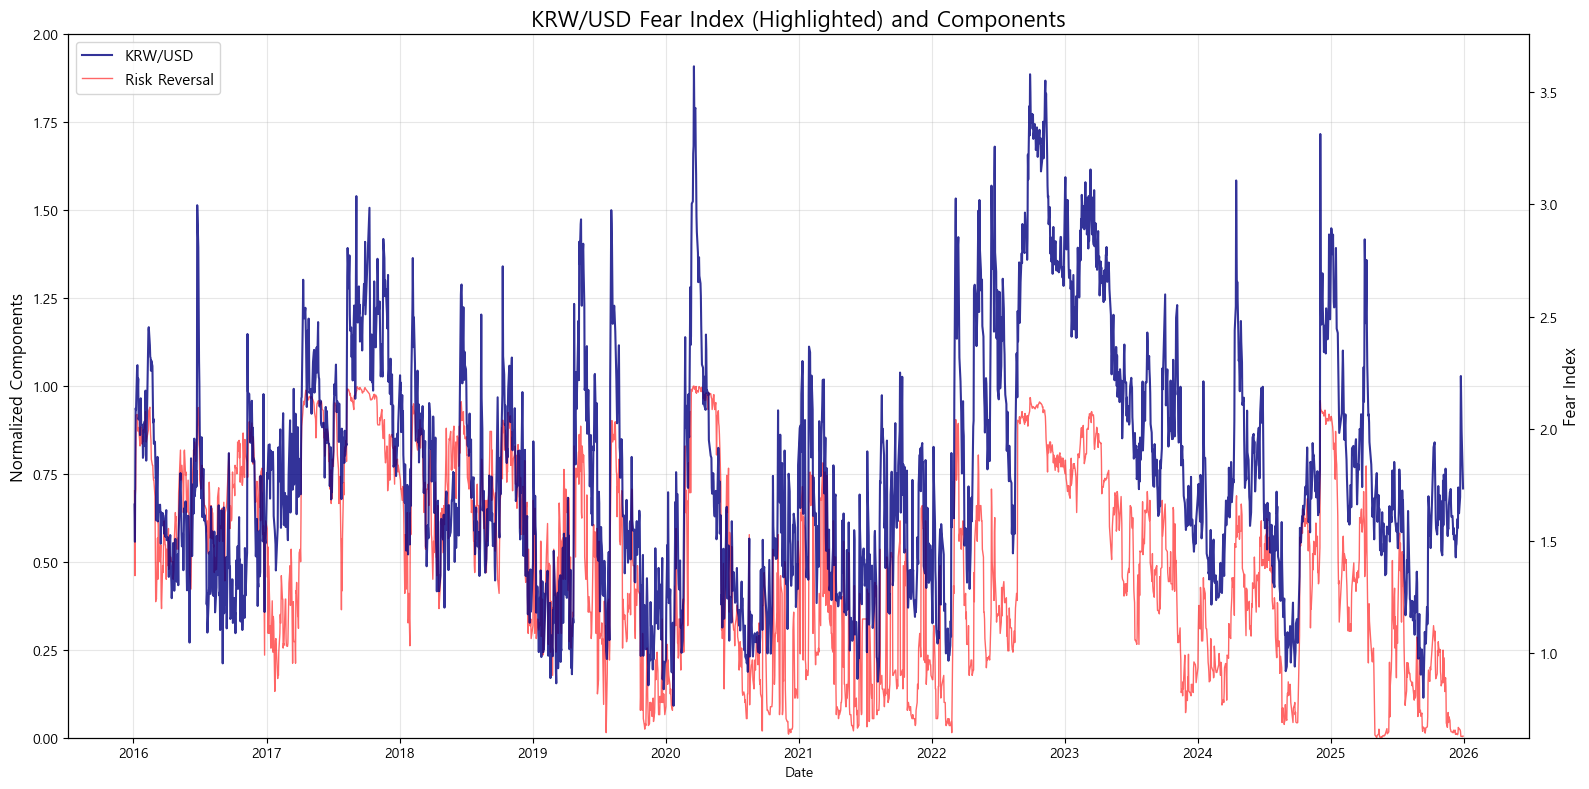

In [39]:
fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Components', fontsize=12)
'''
l1, = ax1.plot(
    merged_df.index, merged_df['cds_norm'],
    label='CDS (percentile)', color='darkred', alpha=0.6
)


l2, = ax1.plot(
    merged_df.index, merged_df['trend_norm'],
    color='orange', alpha=0.6, label='Google Trend'
)

l3, = ax1.plot(
    merged_df.index, merged_df['navertrend_norm'],
    color='green', alpha=0.6, label='Naver Trend'
)
'''
l4, = ax1.plot(
    merged_df.index, merged_df['RR_norm'],
    color='red', alpha=0.6, linewidth=1, label='Risk Reversal'
)

ax1.set_ylim(0, 2.0)
ax1.grid(True, alpha=0.3)

# ===== 오른쪽 축: Fear Index (주인공) =====
ax2 = ax1.twinx()
ax2.set_ylabel('Fear Index', fontsize=12)

l5, = ax2.plot(
    merged_df.index, merged_df['fear_index'],
    label='KRW/USD', color='navy', alpha=0.8
)

# ===== 범례 =====
lines = [l5, l4]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11)

plt.title('KRW/USD Fear Index (Highlighted) and Components', fontsize=16)
plt.tight_layout()
plt.show()


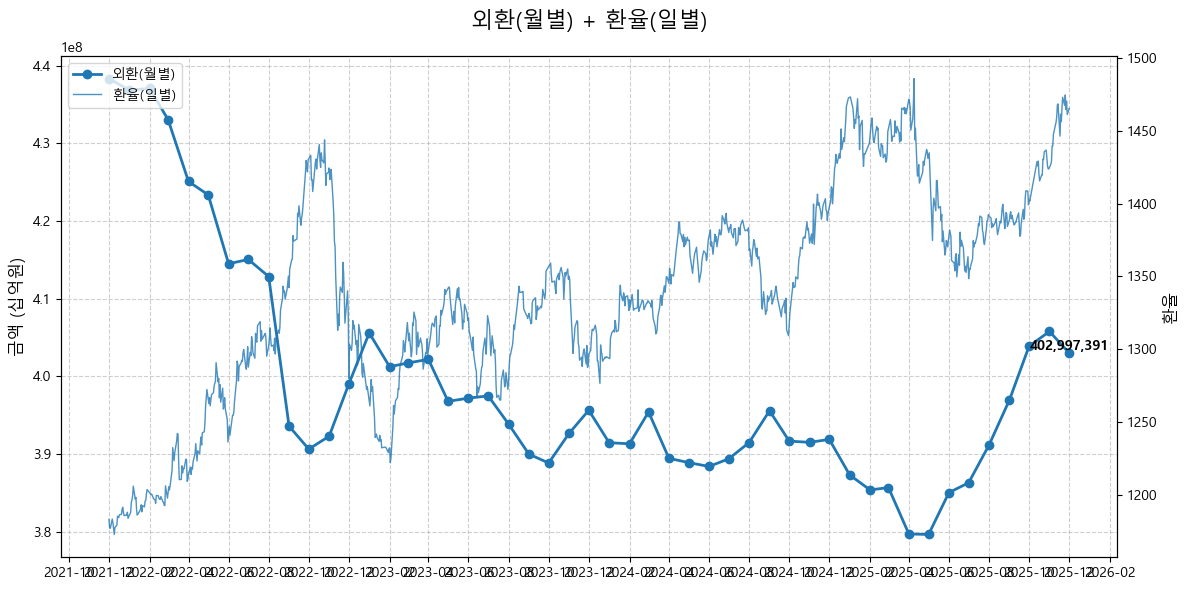

In [ ]:
import matplotlib.dates as mdates

# 1. 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 2. 데이터 불러오기 (사용자 경로 반영)
foreign_currency = pd.read_csv("../dataset/외환보유액_21년~25년.csv")
foreign_currency.columns = foreign_currency.columns.str.strip()
foreign_currency['계정항목'] = foreign_currency['계정항목'].astype(str).str.strip()
target_row = foreign_currency[foreign_currency['계정항목'] == '외환']

cols_to_drop = ['통계표', '계정항목', '단위', '변환']
ts_data = target_row.drop(cols_to_drop, axis=1)
ts_data = ts_data.transpose()
ts_data.columns = ['Value'] 
ts_data.index = pd.to_datetime(ts_data.index, format='%Y/%m')
ts_data['Value'] = ts_data['Value'].astype(str).str.replace(',', '').astype(float)


start = max(ts_data.index.min(), merged_df.index.min())
end   = min(ts_data.index.max(), merged_df.index.max())

ts_plot = ts_data.loc[(ts_data.index >= start) & (ts_data.index <= end)].copy()
fx_plot = merged_df.loc[(merged_df.index >= start) & (merged_df.index <= end)].copy()

fig, ax1 = plt.subplots(figsize=(12, 6))

# 월별 금액(왼쪽 축)
ax1.plot(ts_plot.index, ts_plot['Value'], marker='o', linewidth=2, label='외환(월별)')
ax1.set_title('외환(월별) + 환율(일별)', fontsize=16, pad=20)
ax1.set_ylabel('금액 (십억원)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)

# x축 포맷 (일별 데이터가 많으니 MonthLocator 추천)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 일별 환율(오른쪽 축)
ax2 = ax1.twinx()
ax2.plot(fx_plot.index, fx_plot['real_rate'], linewidth=1, alpha=0.8, label='환율(일별)')
ax2.set_ylabel('환율', fontsize=12)

# 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 마지막 값 라벨(월별)
last_date = ts_plot.index[-1]
last_val = ts_plot['Value'].iloc[-1]
ax1.text(last_date, last_val, f'{last_val:,.0f}', ha='center', va='bottom', fontweight='bold')

fig.tight_layout()
plt.show()

외화예금은 미국증시에 영향을 많이 받기도 하고 환율이 올랐을 때 오히려 외환스왑으로 인해서 보유량이 줄어드는 경우가 있음 (예를 들어 2025년 4월) 직접 가져다 쓰는건 부적절해보임

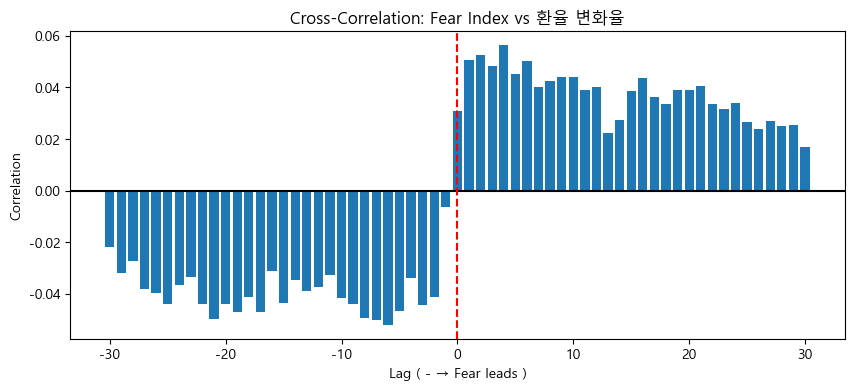

[np.float64(-0.021761216703345816), np.float64(-0.031972099355215965), np.float64(-0.027375836380967602), np.float64(-0.03817576091834239), np.float64(-0.03982491607461579), np.float64(-0.04406359872810969), np.float64(-0.036836611286163515), np.float64(-0.03338810253102387), np.float64(-0.044104516390001534), np.float64(-0.04981605188108116), np.float64(-0.04399171665973876), np.float64(-0.04719529918601621), np.float64(-0.04134971377794378), np.float64(-0.04721026054131027), np.float64(-0.03140475056428557), np.float64(-0.04354039459237465), np.float64(-0.03479711322500768), np.float64(-0.038916713464641), np.float64(-0.037386893432423976), np.float64(-0.032729113774786885), np.float64(-0.04151578641262427), np.float64(-0.0439001104869278), np.float64(-0.04956147858684153), np.float64(-0.050069227868601546), np.float64(-0.05206539303771283), np.float64(-0.04656329575305321), np.float64(-0.03383468760695109), np.float64(-0.04434931376183658), np.float64(-0.041281291264151546), np.floa

In [20]:
import numpy as np

merged_df['fear_index'] = merged_df['cds_norm'] + merged_df['trend_norm'] + merged_df['RR_Z'] + merged_df['navertrend_norm']
fear = merged_df['fear_index']
rate = merged_df['real_rate']

# 각 날들의 전날대비 증가율 데이터
# log(USD/KRW_[t] / USD/KRW_[t-1])
rate_ret = np.log(rate / rate.shift(1))

max_lag = 30
lags = range(-max_lag, max_lag+1)
ccf = [fear.corr(rate_ret.shift(lag)) for lag in lags]
# lag = -30: 30일 후 환율 변화율과의 correlation
# lag = +30: 30일 전 환율 변화율과의 correlation

plt.figure(figsize=(10,4))
plt.bar(lags, ccf)
plt.axhline(0, color='black')
plt.axvline(0, color='red', linestyle='--')

plt.title("Cross-Correlation: Fear Index vs 환율 변화율")
plt.xlabel("Lag ( - → Fear leads )")
plt.ylabel("Correlation")
plt.show()

print(ccf)

In [18]:
rate

date
2016-01-04    1174.109985
2016-01-05    1187.359985
2016-01-06    1188.719971
2016-01-07    1198.739990
2016-01-08    1195.390015
                 ...     
2025-12-23    1476.839966
2025-12-24    1478.670044
2025-12-26    1446.520020
2025-12-29    1441.329956
2025-12-30    1434.709961
Name: real_rate, Length: 2438, dtype: float64

공포지수와 환율 변동은 음의 상관관계가 있다는 결과? 시간 범위를 더 넓게 해서 다시 분석해봐야 할 듯

<Axes: title={'center': 'Fear quantile vs Future 5D FX volatility'}, xlabel='fear_q'>

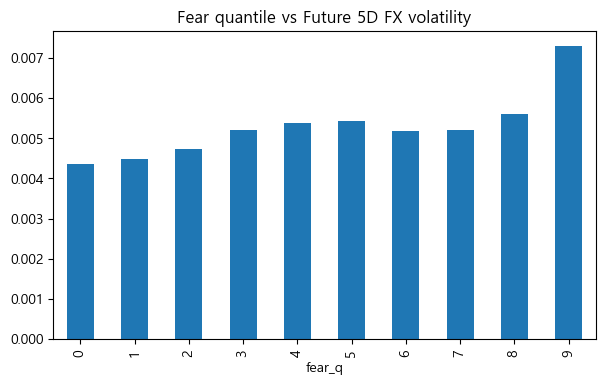

In [12]:
# fear 구간을 5개로 나눠서 fear이 높아짐에 따라 향후 n일 간 변동성이 높아지는지 확인

window = 5 # 뒤로 몇일동안 변동성을 계산할건지
merged_df['future_vol'] = rate_ret.rolling(window).std().shift(-1 * window)

tmp = merged_df[['fear_index','future_vol']].dropna()
# 0: fear 가장 낮은 20%
# 4: fear 가장 높은 20%
tmp['fear_q'] = pd.qcut(tmp['fear_index'], 10, labels=False)
tmp.groupby('fear_q')['future_vol'].mean()

res = tmp.groupby('fear_q')['future_vol'].mean()

res.plot(kind='bar', figsize=(7,4), title='Fear quantile vs Future 5D FX volatility')

위 그래프에서 볼 수 있듯이 Fear 이 높은 구간으로 갈 수록 향후 몇일간의 환율 등락 변동성이 커짐

In [35]:
from statsmodels.tsa.stattools import grangercausalitytests

data = merged_df[['future_vol', 'fear_index']].dropna()
grangercausalitytests(data, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0393  , p=0.8430  , df_denom=230, df_num=1
ssr based chi2 test:   chi2=0.0399  , p=0.8418  , df=1
likelihood ratio test: chi2=0.0398  , p=0.8418  , df=1
parameter F test:         F=0.0393  , p=0.8430  , df_denom=230, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.9067  , p=0.0012  , df_denom=227, df_num=2
ssr based chi2 test:   chi2=14.1176 , p=0.0009  , df=2
likelihood ratio test: chi2=13.7048 , p=0.0011  , df=2
parameter F test:         F=6.9067  , p=0.0012  , df_denom=227, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.0484  , p=0.0021  , df_denom=224, df_num=3
ssr based chi2 test:   chi2=15.6185 , p=0.0014  , df=3
likelihood ratio test: chi2=15.1132 , p=0.0017  , df=3
parameter F test:         F=5.0484  , p=0.0021  , df_denom=224, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5981  , p=0.0014  

{np.int64(1): ({'ssr_ftest': (np.float64(0.039338887681864936),
    np.float64(0.8429539972747238),
    np.float64(230.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.03985200360815013),
    np.float64(0.8417702245323269),
    np.int64(1)),
   'lrtest': (np.float64(0.03984859587990286),
    np.float64(0.8417769003711266),
    np.int64(1)),
   'params_ftest': (np.float64(0.03933888768189712),
    np.float64(0.8429539972746232),
    np.float64(230.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(6.906686025651871),
    np.float64(0.0012251430428792463),
    np.float64(227.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(14.117631347587965),
    np.float64(0.0008597957698873591),
    np.int64(2)),
   'lrtest': (np.float64(13.704756475140584),
    np.float64(0.0010569390493489887),
    np.int64(2)),
   'params_ftest': (np.float64(6.906686025652901),
    np.float64(0.0012251430428780344),
    np.float64(227.0),
    2.0)},
   array([[0., 0., 1., 

환전 시뮬레이션

{'final_krw': np.float64(1387927.5015012063), 'CAGR_est': np.float64(0.034464321130300624), 'MDD': -0.12577596230959887, 'num_trades': 29, 'buy_th': 1.5, 'sell_th': 2.5, 'fee_bps_each_trade': 10.0, 'signal_uses_next_day': True, 'start': Timestamp('2016-01-04 00:00:00'), 'end': Timestamp('2025-12-30 00:00:00')}


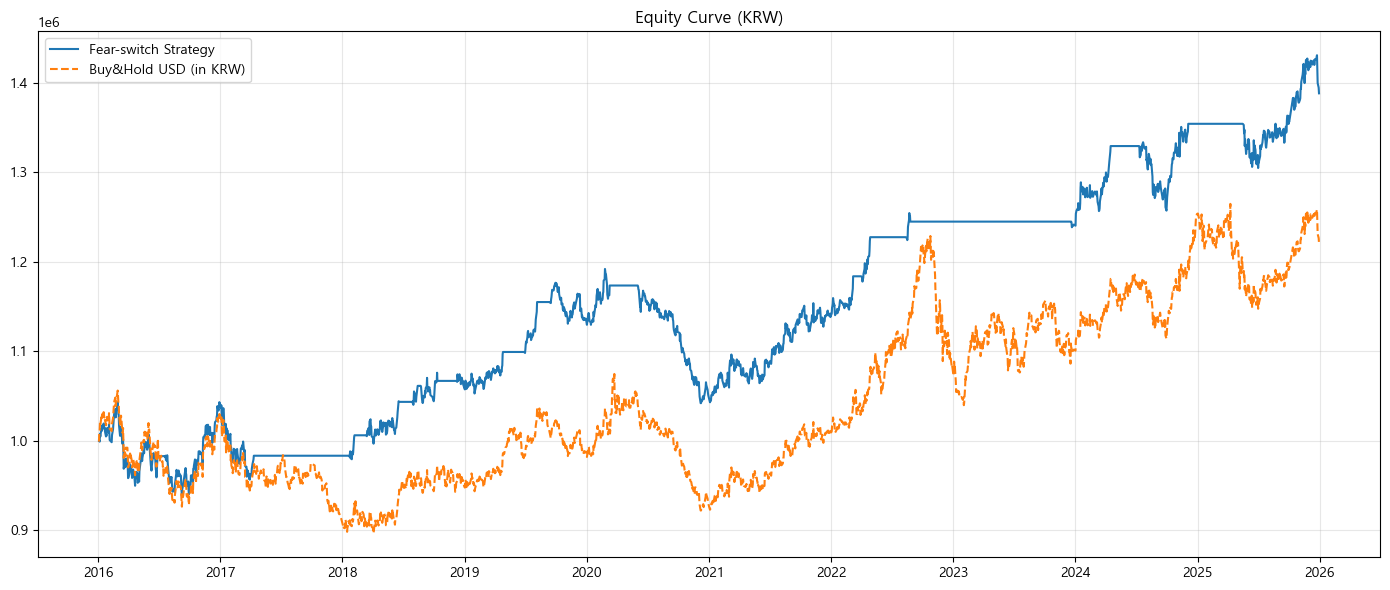

In [45]:
import numpy as np
import pandas as pd

def backtest_fx_fear_switch(
    merged_df: pd.DataFrame,
    fear_col: str = "fear_index",
    rate_col: str = "real_rate",
    buy_th: float = 1.0,   # fear < buy_th => KRW -> USD
    sell_th: float = 3.0,  # fear > sell_th => USD -> KRW
    initial_krw: float = 1_000_000.0,
    fee_bps: float = 10.0, # 환전 비용(왕복이 아니라 '한 번 환전'당) 10bp=0.10%
    use_next_day: bool = True
):
    df = merged_df[[fear_col, rate_col]].copy().dropna()
    df = df.sort_index()

    # 신호를 다음날 적용(치팅 방지)
    fear_sig = df[fear_col].shift(1) if use_next_day else df[fear_col]

    # 목표 포지션: 0=KRW, 1=USD
    # fear < buy_th => USD 보유
    # fear > sell_th => KRW 보유
    target = pd.Series(np.nan, index=df.index, dtype=float)
    target[fear_sig < buy_th] = 1.0
    target[fear_sig > sell_th] = 0.0
    target = target.ffill().fillna(0.0)  # 처음엔 KRW부터 시작

    # 거래 발생(포지션 변경) 체크
    trade = target.diff().fillna(0.0) != 0

    fee = fee_bps / 10_000.0  # bps -> 비율
    rate = df[rate_col].astype(float)

    # 자산 상태
    krw = initial_krw
    usd = 0.0

    equity_krw = []
    pos_hist = []
    trade_hist = []

    for t in range(len(df)):
        date = df.index[t]
        r = rate.iloc[t]
        desired = int(target.iloc[t])

        # 포지션 변경 시 환전
        if trade.iloc[t]:
            if desired == 1:
                # KRW -> USD (수수료 적용)
                usd = (krw * (1 - fee)) / r
                krw = 0.0
            else:
                # USD -> KRW
                krw = (usd * (1 - fee)) * r
                usd = 0.0

        # 평가액(항상 KRW로 평가)
        value = krw + usd * r
        equity_krw.append(value)
        pos_hist.append(desired)
        trade_hist.append(bool(trade.iloc[t]))

    out = df.copy()
    out["position"] = pos_hist  # 0=KRW, 1=USD
    out["trade"] = trade_hist
    out["equity_krw"] = equity_krw
    out["ret"] = out["equity_krw"].pct_change().fillna(0.0)

    # 벤치마크 1: 계속 KRW (현금)
    out["bh_krw"] = initial_krw

    # 벤치마크 2: 처음에 USD로 환전해서 계속 보유
    usd0 = (initial_krw * (1 - fee)) / rate.iloc[0]
    out["bh_usd_in_krw"] = usd0 * rate

    # 성과 요약
    def max_drawdown(x: pd.Series) -> float:
        cummax = x.cummax()
        dd = x / cummax - 1
        return dd.min()

    n_days = len(out)
    years = n_days / 252.0  # 거래일 가정
    final_val = out["equity_krw"].iloc[-1]
    cagr = (final_val / initial_krw) ** (1 / years) - 1 if years > 0 else np.nan
    mdd = max_drawdown(out["equity_krw"])
    trades = out["trade"].sum()

    summary = {
        "final_krw": final_val,
        "CAGR_est": cagr,
        "MDD": mdd,
        "num_trades": int(trades),
        "buy_th": buy_th,
        "sell_th": sell_th,
        "fee_bps_each_trade": fee_bps,
        "signal_uses_next_day": use_next_day,
        "start": out.index.min(),
        "end": out.index.max(),
    }

    return out, summary

# ===== 실행 예시 =====
bt, summary = backtest_fx_fear_switch(
    merged_df,
    buy_th=1.5,
    sell_th=2.5,
    initial_krw=1_000_000,
    fee_bps=10.0,       # 예: 0.10%/환전
    use_next_day=True   # 치팅 방지
)

print(summary)

# ===== 간단 시각화 =====
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(bt.index, bt["equity_krw"], label="Fear-switch Strategy")
plt.plot(bt.index, bt["bh_usd_in_krw"], linestyle="--", label="Buy&Hold USD (in KRW)")
plt.title("Equity Curve (KRW)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


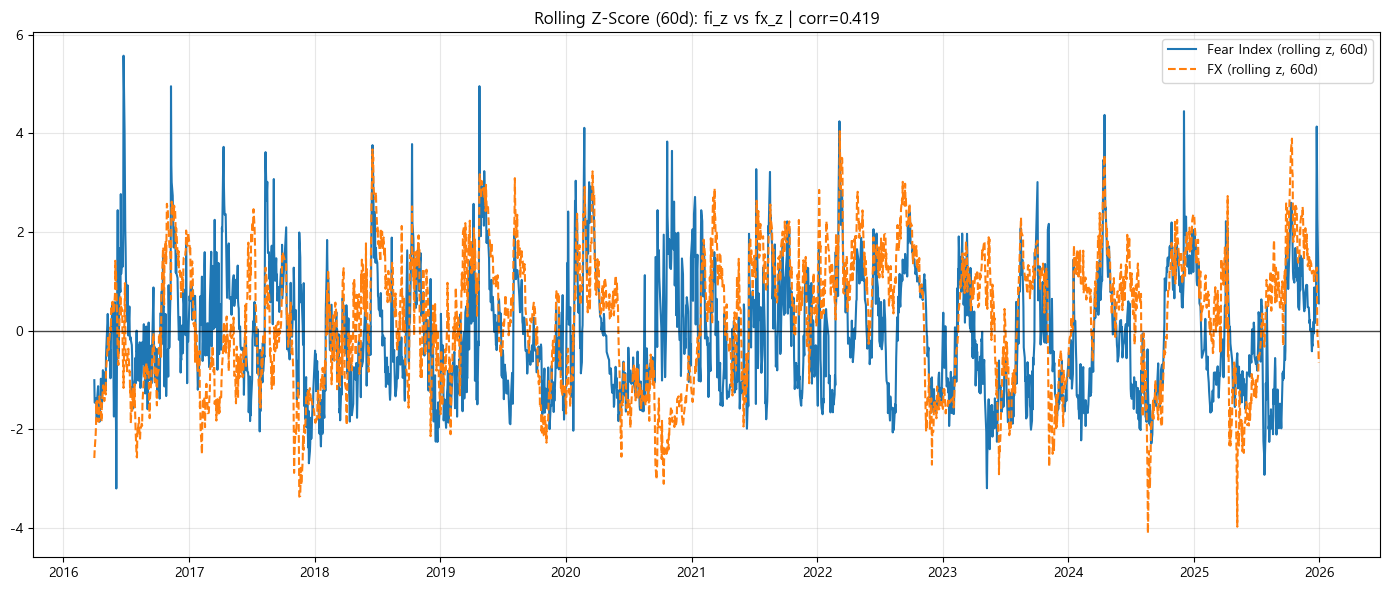

,fi_z,fx_z
fi_z,1.000000,0.418523
fx_z,0.418523,1.000000


In [49]:
fx = merged_df['real_rate']

merged_df['fx_z'] = (
    fx - fx.rolling(60).mean()
) / fx.rolling(60).std()

merged_df['fi_z'] = (
    merged_df['fear_index'] - merged_df['fear_index'].rolling(60).mean()
) / merged_df['fear_index'].rolling(60).std()

corr = merged_df[['fi_z','fx_z']].corr().iloc[0, 1]

# --- 그래프 ---
plt.figure(figsize=(14, 6))
plt.plot(merged_df.index, merged_df['fi_z'], label='Fear Index (rolling z, 60d)')
plt.plot(merged_df.index, merged_df['fx_z'], label='FX (rolling z, 60d)', linestyle='--')
plt.axhline(0, color='black', linewidth=1, alpha=0.7)
plt.title(f'Rolling Z-Score (60d): fi_z vs fx_z | corr={corr:.3f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

merged_df[['fi_z','fx_z']].corr()

lag     0.000000
corr    0.418523
Name: 30, dtype: float64


C:\Users\kdjam\AppData\Local\Temp\ipykernel_24928\2711356991.py:27: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\kdjam\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


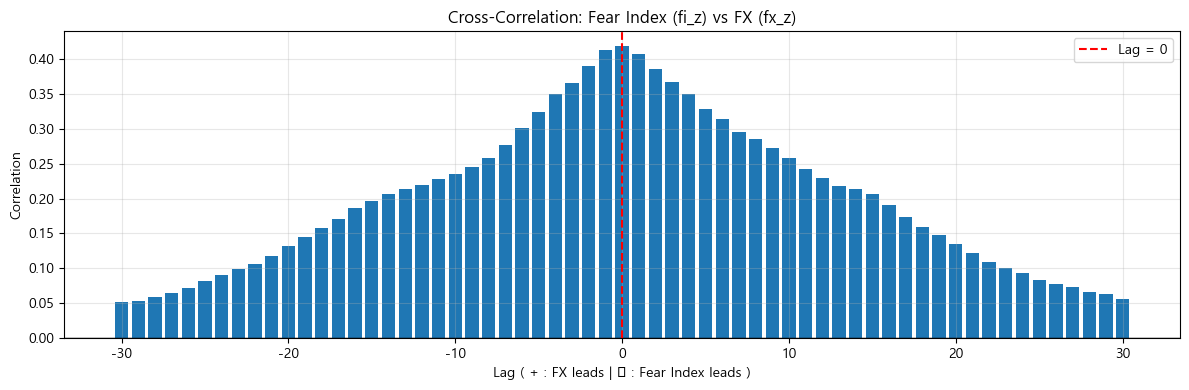

In [51]:
max_lag = 30
lags = range(-max_lag, max_lag + 1)

ccf = [
    merged_df['fi_z'].corr(merged_df['fx_z'].shift(lag))
    for lag in lags
]

# --- 결과 확인 ---
ccf_df = pd.DataFrame({
    'lag': lags,
    'corr': ccf
})

print(ccf_df.loc[ccf_df['corr'].abs().idxmax()])

# --- 시각화 ---
plt.figure(figsize=(12, 4))
plt.bar(lags, ccf)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='red', linestyle='--', label='Lag = 0')
plt.title('Cross-Correlation: Fear Index (fi_z) vs FX (fx_z)')
plt.xlabel('Lag ( + : FX leads | − : Fear Index leads )')
plt.ylabel('Correlation')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()